In [1]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv

load_dotenv(r".\backend\.env")

# add to path
import sys
sys.path.append(r".\backend")

%load_ext autoreload
%autoreload 2

In [4]:
from app import models, schemas
from app.database import get_db
from app.semantic_search import vector_client, QDRANT_COLLECTION_NAME
from app.semantic_search.embedding import TextEmbeddingGenerator


# ITEM MODEL:
#     name: str
#     description: str
#     main_category: str
#     sub_category: str
#     image_url: str
#     stock_quantity: int
#     price: float

db = get_db()

def add_item_to_db(item: dict):
    new_item = models.Item(**item)
    db.add(new_item)
    db.commit()
    db.refresh(new_item)

    # add item to  vector db
    new_item_name_descr = new_item.name + " " + new_item.description
    _ = vector_client.index_item(QDRANT_COLLECTION_NAME, new_item.id, new_item.name, new_item_name_descr, new_item.image_url)

In [17]:
from tqdm import tqdm

tqdm.pandas(desc="Adding products to the database...")


def add_product(row: pd.Series):
    """Add product directly to the database."""
    item = {
        "name": row["product_name"],
        "description": row["product_description"],
        "main_category": row["product_class"],
        "sub_category": "",
        "image_url": "https://cdn-icons-png.flaticon.com/256/8787/8787137.png",
        "stock_quantity": 5,
        "price": 5.99
    }

    add_item_to_db(item)

## Add data to db

In [4]:
# get products
product_df = pd.read_csv("data_eval_prepared/product_cleaned.csv", sep='\t')

In [5]:
from concurrent.futures import ProcessPoolExecutor

def process_dataframe_chunk(chunk):
    chunk.progress_apply(add_product, axis=1)


df_chunks = np.array_split(product_df, 6)  # Split the dataframe into 6 chunks

with ProcessPoolExecutor(max_workers=6) as executor:
    executor.map(process_dataframe_chunk, df_chunks)

Adding products to the database...: 100%|██████████| 39753/39753 [56:32<00:00, 11.72it/s]  


0        None
1        None
2        None
3        None
4        None
         ... 
39748    None
39749    None
39750    None
39751    None
39752    None
Length: 39753, dtype: object

In [10]:
query_df = pd.read_csv("data_eval_prepared/query_cleaned.csv", sep='\t')
labels_df = pd.read_csv("data_eval_prepared/label_cleaned.csv", sep='\t')
product_df = pd.read_csv("data_eval_prepared/product_cleaned.csv", sep='\t')

In [5]:
product_df["name_descr"] = product_df["product_name"] + " " + product_df["product_description"]

<Axes: >

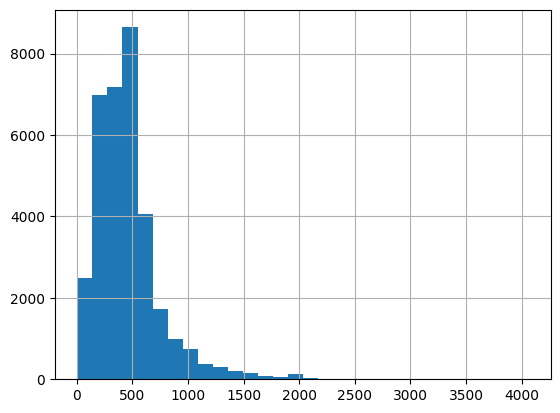

In [10]:
# show histogram of length of name_descr column
product_df["product_description"].str.len().hist(bins=30)

In [13]:
queries = query_df["query"].tolist()
queries

['salon chair',
 'smart coffee table',
 'dinosaur',
 'turquoise pillows',
 'chair and a half recliner',
 'sofa with ottoman',
 'acrylic clear chair',
 'driftwood mirror',
 'home sweet home sign',
 'coffee table fire pit',
 'king poster bed',
 'ombre rug',
 'large spoon and fork wall decor',
 'outdoor privacy wall',
 'beds that have leds',
 'black 5 drawer dresser by guilford',
 'blk 18x18 seat cushions',
 'closet storage with zipper',
 'chrome bathroom 4 light vanity light',
 'gurney  slade 56',
 'foutains with brick look',
 'living curtains pearl',
 'light and navy blue decorative pillow',
 'stoneford end tables white and wood',
 'wood coffee table set by storage',
 'sunflower',
 'leather chairs',
 'outdoor welcome rug',
 'rooster decor',
 'bathroom vanity knobs',
 '3 1/2 inch drawer pull',
 'burnt orange curtains',
 'dark gray dresser',
 'non slip shower floor tile',
 'bar stool with backrest',
 'enclosed shoe rack',
 'laundry basket with wheels',
 'bar stool 24 inches height',
 'cal

In [14]:
import os

TEXT_EMBEDDING_MODEL = os.getenv("TEXT_EMBEDDING_MODEL")
text_embedding_generator = TextEmbeddingGenerator(model_name=TEXT_EMBEDDING_MODEL)
query_vector = text_embedding_generator.generate_embedding("window wall accent")

vector_client.search(QDRANT_COLLECTION_NAME, query_vector=query_vector, search_type="title", top_k=15)

[{'item_id': 18522, 'score': 0.71575356},
 {'item_id': 29252, 'score': 0.7008922},
 {'item_id': 29250, 'score': 0.6787871},
 {'item_id': 26968, 'score': 0.65958774},
 {'item_id': 29249, 'score': 0.6477128},
 {'item_id': 29251, 'score': 0.6212919},
 {'item_id': 26049, 'score': 0.6201092},
 {'item_id': 32451, 'score': 0.6010672},
 {'item_id': 26044, 'score': 0.58638144},
 {'item_id': 16225, 'score': 0.5856264},
 {'item_id': 25716, 'score': 0.5774458},
 {'item_id': 25706, 'score': 0.5774458},
 {'item_id': 19625, 'score': 0.57454956},
 {'item_id': 37365, 'score': 0.5652857},
 {'item_id': 9308, 'score': 0.5623131}]